In [1]:
from __future__ import print_function
import sys
import ctypes
from ctypes import c_double
import numpy as np
from lammps import lammps, LMP_TYPE_ARRAY, LMP_STYLE_GLOBAL
from matplotlib import pyplot as plt
#plt.rcParams.update({'font.size': 18})
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
import torch
from torch import nn
from torch import tensor

In [70]:
def create_torch_network(layer_sizes):
    """
    Creates a pytorch network architecture from layer sizes.
    This also performs standarization in the first linear layer.
    This only supports softplus as the nonlinear activation function.

        Parameters:
            layer_sizes (list of ints): Size of each network layers

        Return:
            Network Architecture of type neural network sequential

    """
    layers = []
    try:

        layers.append(torch.nn.Linear(layer_sizes[0], layer_sizes[0]))
        for i, layer in enumerate(layer_sizes):
            layers.append(torch.nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            layers.append(torch.nn.Softplus())
            #layers.append(torch.nn.ReLU())
    except IndexError:
        layers.pop()

    # Fill weights with ones
    """
    nlayers = len(layers)
    print(f"{nlayers} layers.")
    for l in range(0,nlayers):
        print(layers[l])
        if (isinstance(layers[l],nn.Linear)):
            print(f"Linear layer l={l}")
            layers[l].weight.data.fill_(1.0)
            layers[l].bias.data.fill_(0.05)
    """

    return torch.nn.Sequential(*layers)

"""
Define the model
"""
class FitTorch(torch.nn.Module):
    """
    FitSNAP PyTorch Neural Network Architecture Model
    Currently only fits on energies
    """

    def __init__(self, network_architecture, descriptor_count, n_elements=1):
        """
        Saves lammps ready pytorch model.

            Parameters:
                network_architecture : A nn.Sequential network architecture
                descriptor_count (int): Length of descriptors for an atom
                n_elements (int): Number of differentiable atoms types

        """
        super().__init__()
        self.network_architecture = network_architecture
        self.desc_len = descriptor_count
        self.n_elem = n_elements

    def forward(self, x, xd, indices, atoms_per_structure, force_indices):
        """
        Saves lammps ready pytorch model.

            Parameters:
                x (tensor of floats): Array of descriptors
                x_derivatives (tensor of floats): Array of descriptor derivatives
                indices (tensor of ints): Array of indices upon which to contract per atom energies
                atoms_per_structure (tensor of ints): Number of atoms per configuration

        """
        #print(x_derivatives.size())
        nbatch = int(x.size()[0]/natoms)
        #print(f"{nbatch} configs in this batch")

        # Calculate energies
        predicted_energy_total = torch.zeros(atoms_per_structure.size())
        predicted_energy_total.index_add_(0, indices, self.network_architecture(x).squeeze())


        # Calculate forces
        x_indices = force_indices[0::3]
        y_indices = force_indices[1::3]
        z_indices = force_indices[2::3]
        #print(np.shape(force_indices))
        atom_indices = torch.tensor(force_indices[0::3,1].astype(int)-1,dtype=torch.long) # Atoms i are repeated for each cartesian direction
        neigh_indices = torch.tensor(force_indices[0::3,0].astype(int)-1,dtype=torch.long) # Neighbors j are repeated for each cartesian direction
        #print(neigh_indices.size())
        #print(int(neigh_indices))
        #dEdD = torch.autograd.grad(self.network_architecture(x), x, grad_outputs=torch.ones_like(self.network_architecture(x)))
        dEdD = torch.autograd.grad(self.network_architecture(x), x, grad_outputs=torch.ones_like(self.network_architecture(x)))
        #print(dEdD[0])
        dEdD = dEdD[0][neigh_indices,:] # These need to be dotted with dDdR in the x, y, and z directions.
        #print(dEdD)
        dDdRx = xd[0::3]
        dDdRy = xd[1::3]
        dDdRz = xd[2::3]
        #print(dDdRx)
        #print(x)
        #print(dEdD.size())
        #print(dDdRx.size())
        elementwise_x = torch.mul(dDdRx, dEdD)
        elementwise_y = torch.mul(dDdRy, dEdD)
        elementwise_z = torch.mul(dDdRz, dEdD)
        #print(elementwise)
        # Need to contract these along rows with indices given by force_indices[:,1]
        #print(atom_indices)
        fx_components = torch.zeros(natoms,nd)
        fy_components = torch.zeros(natoms,nd)
        fz_components = torch.zeros(natoms,nd)
        #print(fx_components.size())
        contracted_x = fx_components.index_add_(0,atom_indices,elementwise_x)
        contracted_y = fy_components.index_add_(0,atom_indices,elementwise_y)
        contracted_z = fz_components.index_add_(0,atom_indices,elementwise_z)
        #print(contracted.size())
        # Sum along bispectrum components to get force on each atom.
        predicted_fx = torch.sum(contracted_x, dim=1)
        predicted_fy = torch.sum(contracted_y, dim=1)
        predicted_fz = torch.sum(contracted_z, dim=1)
        # Reshape to get 2D tensor
        predicted_fx = torch.reshape(predicted_fx, (natoms,1))
        predicted_fy = torch.reshape(predicted_fy, (natoms,1))
        predicted_fz = torch.reshape(predicted_fz, (natoms,1))
        # Concatenate along the columns
        predicted_forces = torch.cat((predicted_fx,predicted_fy,predicted_fz), dim=1)
        #print(predicted_forces.size())
        #print(x)
        #print(dEdD)
        #predicted_forces = torch.zeros(nconfigs*natoms)
        """
        # Loop over all configs given by number of rows in descriptors array
        for m in range(0,nbatch):
            for i in range(0,natoms):
                # Loop over neighbors of i
                numneighs_i = len(neighlists[m,i])
                for jj in range(0,numneighs_i):
                    j = neighlists[m,i,jj]
                    jtag = tags[m,j]
                    for k in range(0,nd):
                        predicted_forces[natoms*m + i] -= x_derivatives[natoms*m + i,(jj*nd)+k]*dEdD[0][natoms*m + jtag,k]
        """

        return (predicted_energy_total, predicted_forces)
        #return predicted_energy_total

    def import_wb(self, weights, bias):
        """
        Imports weights and bias into FitTorch model

            Parameters:
                weights (list of numpy array of floats): Network weights at each layer
                bias (list of numpy array of floats): Network bias at each layer

        """

        assert len(weights) == len(bias)
        imported_parameter_count = sum(w.size + b.size for w, b in zip(weights, bias))
        combined = [None] * (len(weights) + len(bias))
        combined[::2] = weights
        combined[1::2] = bias

        assert len([p for p in self.network_architecture.parameters()]) == len(combined)
        assert sum(p.nelement() for p in self.network_architecture.parameters()) == imported_parameter_count

        state_dict = self.state_dict()
        for i, key in enumerate(state_dict.keys()):
            state_dict[key] = torch.tensor(combined[i])
        self.load_state_dict(state_dict)
        
# LAMMPS setup commands
def prepare_lammps(seed):

    lmp.command("clear")
    lmp.command("units metal")
    lmp.command("boundary	p p p")
    lmp.command("atom_modify	map hash")
    lmp.command(f"lattice         bcc {latparam}")
    lmp.command(f"region		box block 0 {nx} 0 {ny} 0 {nz}")
    lmp.command(f"create_box	{ntypes} box")
    lmp.command(f"create_atoms	{ntypes} box")
    lmp.command("mass 		* 180.88")
    #lmp.command("displace_atoms 	all random 0.1 0.1 0.1 123456")
    lmp.command(f"displace_atoms 	all random 0.1 0.1 0.1 {seed}")
    lmp.command(f"pair_style zero 7.0")
    lmp.command(f"pair_coeff 	* *")
    #lmp.command(f"compute 	snap all snap {snap_options}")
    lmp.command(f"compute 	snap all snap {snap_options}")
    lmp.command(f"compute snapneigh all snapneigh {snap_options}")
    lmp.command(f"thermo 		100")
        
        
# Get model force
def calc_model_forces(x0, seed):
    natoms = int(np.shape(x0)[0]/3)
    prepare_lammps(seed)
    x0 = lmp.numpy.extract_atom("x").flatten()
    for indx in range(0,3*natoms):
        x[indx]=x0[indx]
    lmp.scatter_atoms("x",1,3,x)
    lmp.command(f"run 0")
    #blah = lmp.numpy.extract_atom("x").flatten()
    #print(blah)
    lmp_snap = lmp.numpy.extract_compute("snap",0, 2)
    force_indices = lmp.numpy.extract_compute("snapneigh", 0, 2).astype(np.int32)
    #print(lmp_snap[16:,:])
    #print(force_indices)
    # Calculate energy
    descriptors = lmp_snap[:natoms, :]
    dDdR_length = np.shape(lmp_snap)[0]-natoms-6
    dDdR = lmp_snap[natoms:(natoms+dDdR_length), :]
    descriptors = torch.from_numpy(descriptors).float().requires_grad_()
    dDdR = torch.from_numpy(dDdR).float().requires_grad_()
    #print(descriptors)
    (energies, forces) = model(descriptors, dDdR, indices, num_atoms, force_indices)
    #print(energies)
    #e1 = energies.detach().numpy()[0]
    forces = forces.detach().numpy()
    return forces

# Get finite difference force
def calc_fd_forces(x0, seed):
    
    natoms = int(np.shape(x0)[0]/3)
    
    a = 0
    forces = np.zeros((natoms,3)) # Only x direction for now.
    for i in range(0,natoms):
        for a in range(0,3):
        
            atomindx = 3*i + a

            # +h
            prepare_lammps(seed)
            x0 = lmp.numpy.extract_atom("x").flatten()
            #print(x0)
            #xtmp = x0
            for indx in range(0,3*natoms):
                x[indx]=x0[indx]
            x[atomindx] += h
            x1 = x0
            x1[atomindx] += h
            #if (i==7):
            #    print(x[atomindx])
            lmp.scatter_atoms("x",1,3,x)
            lmp.command(f"run 0")
            #blah = lmp.numpy.extract_atom("x").flatten()
            #print(blah)
            lmp_snap = lmp.numpy.extract_compute("snap",0, 2)
            lmp_snap1 = lmp_snap
            force_indices = lmp.numpy.extract_compute("snapneigh", 0, 2).astype(np.int32)
            #print(lmp_snap[16:,:])
            #print(force_indices)
            # Calculate energy
            descriptors = lmp_snap[:natoms, :]
            d1 = descriptors
            #if (i==7):
            #    print(descriptors)
            dDdR_length = np.shape(lmp_snap)[0]-natoms-6
            dDdR = lmp_snap[natoms:(natoms+dDdR_length), :]
            descriptors = torch.from_numpy(descriptors).float().requires_grad_()
            dDdR = torch.from_numpy(dDdR).float().requires_grad_()
            #print(descriptors)
            (energies, force_junk) = model(descriptors, dDdR, indices, num_atoms, force_indices)
            #print(energies)
            e1 = energies.detach().numpy()[0]

            # -h
            prepare_lammps(seed)
            x0 = lmp.numpy.extract_atom("x").flatten()
            for indx in range(0,3*natoms):
                x[indx]=x0[indx]
            x[atomindx] -= h
            x2 = x0
            x2[atomindx] -= h
            #if (i==7):
            #    print(x[atomindx])
            lmp.scatter_atoms("x",1,3,x)
            lmp.command(f"run 0")
            #blah = lmp.numpy.extract_atom("x").flatten()
            #print(blah)
            lmp_snap = lmp.numpy.extract_compute("snap",0, 2)
            lmp_snap2 = lmp_snap
            force_indices = lmp.numpy.extract_compute("snapneigh", 0, 2).astype(np.int32)
            #print(lmp_snap[16:,:])
            #print(force_indices)
            # Calculate energy
            descriptors = lmp_snap[:natoms, :]
            d2 = descriptors
            #if ((i==7) and (a==2)):
            #    #print(descriptors)
            #    d_diff = np.abs(d1-d2)
            #    print(d1)
            #    print(d2)
            #    print(d_diff)
            #print(descriptors)
            dDdR_length = np.shape(lmp_snap)[0]-natoms-6
            dDdR = lmp_snap[natoms:(natoms+dDdR_length), :]
            descriptors = torch.from_numpy(descriptors).float().requires_grad_()
            dDdR = torch.from_numpy(dDdR).float().requires_grad_()
            (energies, force_junk) = model(descriptors, dDdR, indices, num_atoms, force_indices)
            e2 = energies.detach().numpy()[0]
            
            #if (i==7):
            #    print(f"{e1} {e2}")
            if ((i==7) and (a==2)):
                #print(descriptors)
                d_diff = np.abs(d1-d2)
                print("d1:")
                #print(d1)
                print(lmp_snap1)
                print("x1:")
                print(x1)
                print("d2:")
                #print(d2)
                print(lmp_snap2)
                print("x2:")
                print(x2)
                print("d_diff:")
                print(d_diff)
                print(f"e1, e2: {e1} {e2}")

            force = (e1-e2)/(2*h)
            forces[i,a]=force
            
    return forces
    

In [71]:
# Finite difference parameters
h = 1e-3
# Other parameters
nconfigs=1

# Simulation parameters
nsteps=0
nrep=2
latparam=2.0
nx=nrep
ny=nrep
nz=nrep
ntypes=2
# SNAP options
twojmax=2
m = (twojmax/2)+1
K = int(m*(m+1)*(2*m+1)/6)
print(f"K : {K}")
rcutfac=1.0 #1.0
rfac0=0.99363
rmin0=0
radelem1=1.0
radelem2=1.0
wj1=1.0
wj2=0.96
quadratic=0
bzero=0
switch=0
bikflag=1
dbirjflag=1
#snap_options=f'{rcutfac} {rfac0} {twojmax} {radelem1} {radelem2} {wj1} {wj2} rmin0 {rmin0} quadraticflag {quadratic} bzeroflag {bzero} switchflag {switch}'
snap_options=f'{rcutfac} {rfac0} {twojmax} {radelem1} {radelem2} {wj1} {wj2} rmin0 {rmin0} quadraticflag {quadratic} bzeroflag {bzero} switchflag {switch} bikflag {bikflag} dbirjflag {dbirjflag}'


K : 5


In [72]:
lmp = lammps(cmdargs=["-log", "none", "-screen", "none"])

In [73]:
# Get positions, natoms, number descriptors, length of dbirj
prepare_lammps(1)
lmp.command(f"run 0")
# These need to be run after run 0 otherwise you'll get a segfault since compute variables don't get initialized.
lmp_snap = lmp.numpy.extract_compute("snap",0, 2)
#print(lmp_snap)
force_indices = lmp.numpy.extract_compute("snapneigh", 0, 2).astype(np.int32)
#print(lmp_snap[16:,:])
#print(np.shape(force_indices))
#print(force_indices[0:34,:])
x_indices = force_indices[0::3]
y_indices = force_indices[1::3]
z_indices = force_indices[2::3]
x0 = lmp.numpy.extract_atom("x").flatten()
natoms = lmp.get_natoms()
descriptors = lmp_snap[:natoms, :]
nd = np.shape(descriptors)[1]
dDdR_length = np.shape(lmp_snap)[0]-natoms-6
dDdR = lmp_snap[natoms:(natoms+dDdR_length), :]
#print(np.shape(dDdR)) # Should be same as force_indices
#print(np.shape(force_indices))
# Define indices upon which to contract per-atom energies
indices = []
for m in range(0,nconfigs):
    for i in range(0,natoms):
        indices.append(m)
indices = torch.tensor(indices, dtype=torch.int64)
# Number of atoms per config is needed for future energy calculation.
num_atoms = natoms*torch.ones(nconfigs,dtype=torch.int32)

In [74]:
#Define the network parameters based on number of descriptors
#layer_sizes = ['num_desc', '10', '8', '6', '1'] # FitSNAP style
nd=K
print(f"number descriptors: {nd}")
layer_sizes = [nd, nd, nd, 1]

number descriptors: 5


In [75]:
# Build the model
network_architecture = create_torch_network(layer_sizes)
"""
for name, param in network_architecture.named_parameters():
    print("-----")
    print(name)
    print(param)
"""
model = FitTorch(network_architecture, nd)

In [76]:
#i = 0
#a = 0
#atomindx = 3*i+a
n3 = 3*natoms
# Allocate c array for positions.
x = (n3*c_double)()

start = 2
#end = start+1
end = 3

errors = []
for seed in range(start,end):
    print(seed)
    # Get model forces
    model_forces = calc_model_forces(x0, seed)
    #print(model_forces)
    # Get finite difference forces
    fd_forces = calc_fd_forces(x0, seed)
    #print(fd_forces)
    # Calc difference
    diff = model_forces - fd_forces
    #print(type(diff))
    #print(type(fd_forces))
    percent_error = np.divide(diff, fd_forces)*100
    #percent_error = torch.div(diff,fd_forces)*100
    print(percent_error)
    percent_error = percent_error.flatten()
    #print(percent_error)
    errors.append(percent_error)
    
errors = np.abs(np.array(errors))
errors = errors.flatten()
errors[errors == -np.inf] = 0.1
errors[errors == np.inf] = 0.1
errors[errors == 0] = 0.1
errors[errors == 0] = 0.1
#print(errors)

2
d1:
[[ 2.00000000e+000  1.00000000e+000  0.00000000e+000  2.00000000e+000
   1.00000000e+000]
 [ 1.00000000e+000  2.00000000e+000  1.00000000e+000  2.00000000e+000
   3.00000000e+000]
 [ 1.00000000e+000  0.00000000e+000  3.00000000e+000  1.00000000e+000
   1.00000000e+000]
 ...
 [ 2.59790745e+020  5.66636661e-315  1.24583267e+002  1.55847157e+005
  -3.17255270e+009]
 [-2.11901098e+015  1.61814722e-314 -1.06306075e+006 -7.12880515e+008
  -9.73270417e+011]
 [-1.12229747e+017  1.62112665e-314  3.35403729e+014  5.46973796e+016
  -2.27564480e+012]]
x1:
[3.82871645 0.03736909 0.06221832 1.00557919 1.16944094 1.19390376
 2.07842383 0.06935573 0.06179637 2.99424417 1.06170414 0.86154201
 0.14911631 2.19788614 3.87240336 0.94361266 2.89797308 1.03357476
 2.02029354 1.87359965 3.98924242 2.87564693 2.99789052 1.14695715
 0.15489959 0.19732889 2.10672188 1.03277383 1.02972501 2.98820643
 1.94412486 0.10647525 1.92949869 2.90969544 0.85132934 3.0922122
 3.86267904 2.04654851 1.94074013 1.1662870

Text(0.5, 0, 'Force component percent error (%)')

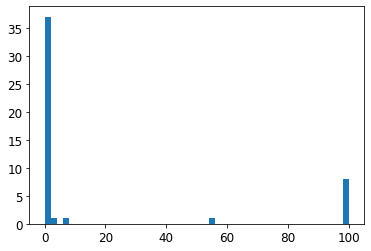

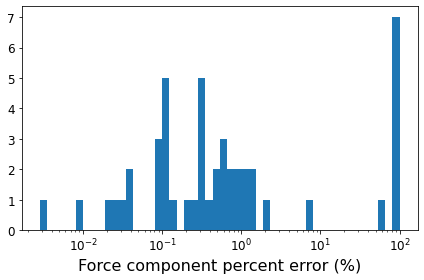

In [38]:
n_bins = 50

# histogram on linear scale
#plt.subplot(111)
hist, bins, _ = plt.hist(errors, bins=n_bins)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
#plt.hist(errors, bins=logbins)
#plt.xscale('log')
#plt.show()


fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
#logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
# We can set the number of bins with the *bins* keyword argument.
axs.hist(errors, bins=logbins)
axs.set_xscale('log')
axs.set_xlabel("Force component percent error (%)")


[0.14495746 0.02455429 0.10840517 ... 0.00635611 0.06566886 0.04437057]


(0.0001, 300.0)

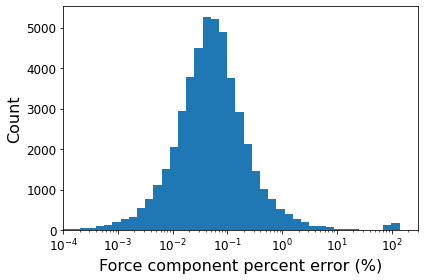

In [71]:
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
#logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
# We can set the number of bins with the *bins* keyword argument.
print(errors)
axs.hist(errors, bins=logbins)
axs.set_xscale('log')
axs.set_xlabel("Force component percent error (%)")
axs.set_ylabel("Count")
axs.set_xlim(1e-4, 3e2)

In [96]:
xtmp = np.array([3.82871645, 0.03736909, 0.06221832, 1.00557919, 1.16944094, 1.19390376,
 2.07842383, 0.06935573, 0.06179637, 2.99424417, 1.06170414, 0.86154201,
 0.14911631, 2.19788614, 3.87240336, 0.94361266, 2.89797308, 1.03357476,
 2.02029354, 1.87359965, 3.98924242, 2.87564693, 2.99789052, 1.14595715,
 0.15489959, 0.19732889, 2.10672188, 1.03277383, 1.02972501, 2.98820643,
 1.94412486, 0.10647525, 1.92949869, 2.90969544, 0.85132934, 3.0922122,
 3.86267904, 2.04654851, 1.94074013, 1.16628709, 2.98705994, 3.11642599,
 2.12569208, 2.10676541, 2.00631599, 3.14939462, 3.07539713, 2.99948012])
print(xtmp)

[3.82871645 0.03736909 0.06221832 1.00557919 1.16944094 1.19390376
 2.07842383 0.06935573 0.06179637 2.99424417 1.06170414 0.86154201
 0.14911631 2.19788614 3.87240336 0.94361266 2.89797308 1.03357476
 2.02029354 1.87359965 3.98924242 2.87564693 2.99789052 1.14595715
 0.15489959 0.19732889 2.10672188 1.03277383 1.02972501 2.98820643
 1.94412486 0.10647525 1.92949869 2.90969544 0.85132934 3.0922122
 3.86267904 2.04654851 1.94074013 1.16628709 2.98705994 3.11642599
 2.12569208 2.10676541 2.00631599 3.14939462 3.07539713 2.99948012]


In [ ]:

n3 = 3*natoms
# Allocate c array for positions.
x = (n3*c_double)()

seed=2
prepare_lammps(seed)
x0 = lmp.numpy.extract_atom("x").flatten()
print(x0)
#xtmp = x0
for indx in range(0,3*natoms):
    x[indx]=x0[indx]
#x[atomindx] += h
#if (i==7):
#    print(x[atomindx])
lmp.scatter_atoms("x",1,3,x)
lmp.command(f"run 0")


#blah = lmp.numpy.extract_atom("x").flatten()
#print(blah)
lmp_snap = lmp.numpy.extract_compute("snap",0, 2)
"""
force_indices = lmp.numpy.extract_compute("snapneigh", 0, 2).astype(np.int32)
#print(lmp_snap[16:,:])
#print(force_indices)
# Calculate energy
descriptors = lmp_snap[:natoms, :]
dDdR_length = np.shape(lmp_snap)[0]-natoms-6
dDdR = lmp_snap[natoms:(natoms+dDdR_length), :]
descriptors = torch.from_numpy(descriptors).float().requires_grad_()
dDdR = torch.from_numpy(dDdR).float().requires_grad_()
#print(descriptors)
(energies, force_junk) = model(descriptors, dDdR, indices, num_atoms, force_indices)
#print(energies)
e1 = energies.detach().numpy()[0]
print(descriptors)
"""